In [2]:
%pwd
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.externals import joblib
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from imblearn.combine import SMOTETomek

#Random Number
r = 42
labels = ['CN', 'EMCI', 'LMCI', 'AD']

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
#Loading in data
df = pd.read_csv('Data/ADNI_Gene_Expression_Profile.csv', header=2)
df = df[6:]
df = df.drop(df.columns[[1, -1]], axis=1)
df = df.rename({'SubjectID':'ProbeSet', 'Unnamed: 2':'Gene'}, axis=1)
df = df.set_index(['Gene', 'ProbeSet'])
df = df.loc[df.index.dropna()]

dfanno = pd.read_csv('Data/ADNIMERGE.csv')
dfanno = pd.Series(dfanno['DX_bl'].values, index=dfanno['PTID'])
dfanno = dfanno.groupby(dfanno.index).last()
dfanno = dfanno.loc[df.columns]

C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (329,480) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Choose Genes
dfanno = dfanno.loc[df.columns]
genes = ['BACE1', 'ABCA7', 'APOE', 'CLU', 'EPHA1', 'FERMT2', 'PTK2B', 'SORL1']
dftop = df.loc[genes]
dftop = dftop.groupby(dftop.index).first()
dftop = dftop.astype(float)

In [5]:
#Counts
print(dfanno.value_counts())

#Find Means of each gene
CN = dftop[dfanno[dfanno=='CN'].index].mean(axis=1)
EMCI = dftop[dfanno[dfanno=='EMCI'].index].mean(axis=1)
LMCI = dftop[dfanno[dfanno=='LMCI'].index].mean(axis=1)
AD = dftop[dfanno[dfanno=='AD'].index].mean(axis=1)

CN      260
LMCI    226
EMCI    215
AD       43
dtype: int64


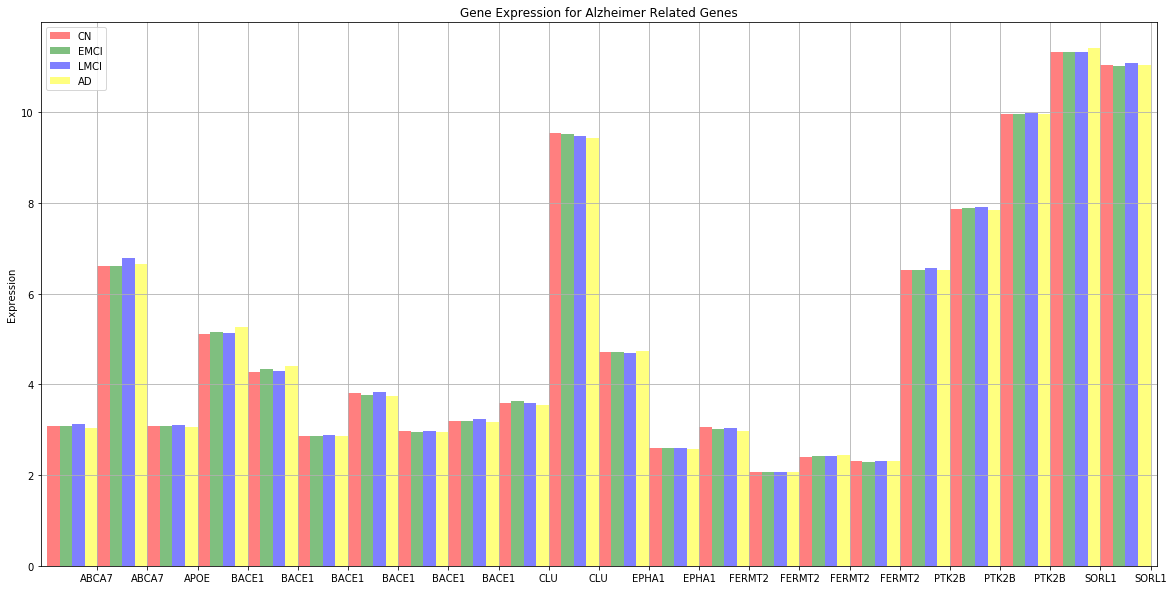

In [6]:
#Graph
# Setting the positions and width for the bars
pos = list(range(len(CN))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

plt.bar(pos, CN, width, alpha=0.5, color='red', label='CN') 
plt.bar([p + width for p in pos], EMCI, width, alpha=0.5, color='green', label='EMCI') 
plt.bar([p + width*2 for p in pos], LMCI, width, alpha=0.5, color='blue', label='LMCI') 
plt.bar([p + width*3 for p in pos], AD, width, alpha=0.5, color='yellow', label='AD') 

ax.set_ylabel('Expression')
ax.set_title('Gene Expression for Alzheimer Related Genes')
ax.set_xticks([p + 3.5 * width for p in pos])
ax.set_xticklabels([x[0] for x in dftop.index])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
plt.legend(['CN', 'EMCI', 'LMCI', 'AD'], loc='upper left')
plt.grid()
plt.show()


In [7]:
#Normalize data
dftop = dftop.sub(dftop.mean(1), axis=0).div(dftop.std(1), axis=0)

#Find Means of each gene
CN = dftop[dfanno[dfanno=='CN'].index].mean(axis=1)
EMCI = dftop[dfanno[dfanno=='EMCI'].index].mean(axis=1)
LMCI = dftop[dfanno[dfanno=='LMCI'].index].mean(axis=1)
AD = dftop[dfanno[dfanno=='AD'].index].mean(axis=1)

#Find variance of each gene
CN_std = dftop[dfanno[dfanno=='CN'].index].std(axis=1)
EMCI_std = dftop[dfanno[dfanno=='EMCI'].index].std(axis=1)
LMCI_std = dftop[dfanno[dfanno=='LMCI'].index].std(axis=1)
AD_std = dftop[dfanno[dfanno=='AD'].index].std(axis=1)

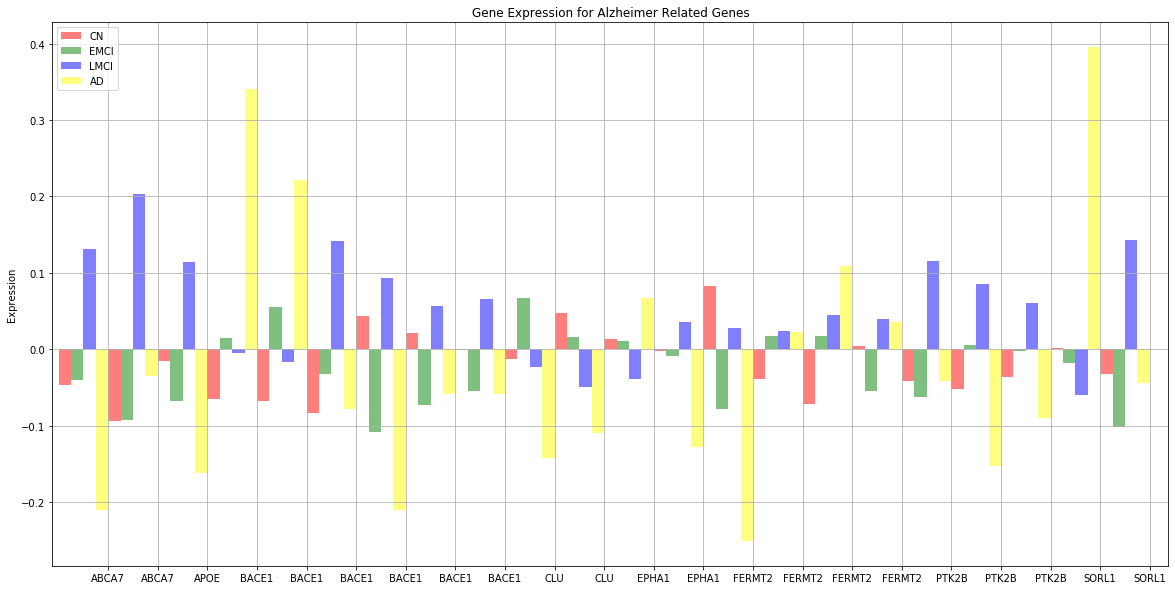

In [8]:
#Graph
# Setting the positions and width for the bars
pos = list(range(len(CN))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

plt.bar(pos, CN, width, alpha=0.5, color='red', label='CN') 
plt.bar([p + width for p in pos], EMCI, width, alpha=0.5, color='green', label='EMCI') 
plt.bar([p + width*2 for p in pos], LMCI, width, alpha=0.5, color='blue', label='LMCI') 
plt.bar([p + width*3 for p in pos], AD, width, alpha=0.5, color='yellow', label='AD') 

ax.set_ylabel('Expression')
ax.set_title('Gene Expression for Alzheimer Related Genes')
ax.set_xticks([p + 3.5 * width for p in pos])
ax.set_xticklabels([x[0] for x in dftop.index])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*5)

# Adding the legend and showing the plot
plt.legend(['CN', 'EMCI', 'LMCI', 'AD'], loc='upper left')
plt.grid()
plt.show()


In [9]:
#Heatmap Gene Expression
def geheatmap(X, c, title=''):
    #Gene Expression
    ge = pd.DataFrame()
    for t in labels:
        ge[t] = X[c[c==t].index].mean(axis=1)

    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 

    #Heatmap
    fig = plt.figure(figsize = (2*c.nunique(),24))
    plt.title(title, fontsize = 20)
    sns.heatmap(ge, cmap='RdBu')

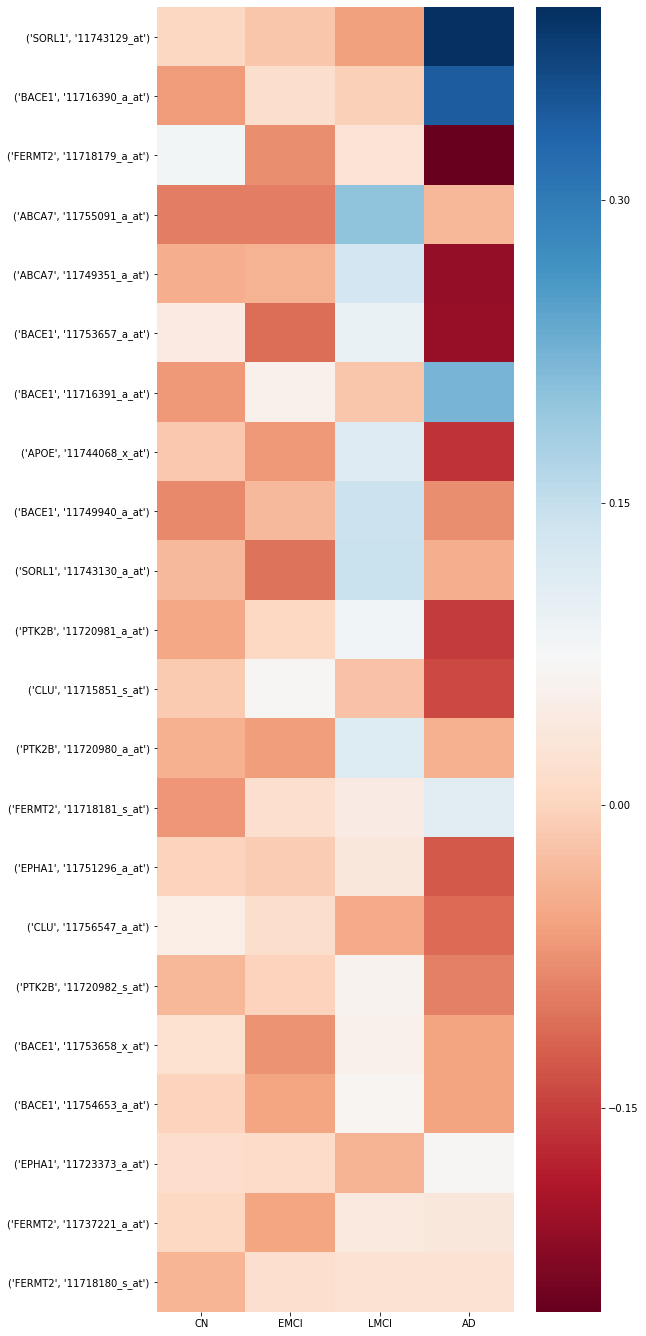

In [10]:
geheatmap(dftop, dfanno)